In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from math import sqrt
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.layers import concatenate
import scikitplot as skplt

In [2]:
data_directory = os.path.expanduser("/home/ronaldsonbellande/Desktop/Data Mining/project/LSTM/")

In [3]:
data_list = pd.read_csv("ny.csv")
data_list

,Unnamed: 0,distance to target,id,period,trip_time_in_secs,trip_distance,longitude,latitude,is_pickup
0,0,1440.000000,1,0,487,2.60,-73.976624,40.751686,1
1,1,1279.083333,1,0,487,2.60,-73.949348,40.776871,0
2,2,1272.616667,1,0,1166,3.10,-73.948524,40.778000,1
3,3,1265.766667,1,0,1166,3.10,-73.978966,40.780052,0
4,4,1262.483333,1,0,380,1.50,-73.979164,40.780136,1
...,...,...,...,...,...,...,...,...,...
299995,299995,1403.000000,143,0,0,0.00,0.000000,0.000000,0
299996,299996,1426.000000,143,0,600,3.46,-73.970535,40.756302,1
299997,299997,1436.000000,143,0,600,3.46,-73.922325,40.762981,0
299998,299998,1438.000000,143,0,1080,5.29,-73.921043,40.763145,1


In [4]:
data_list.columns

Index(['Unnamed: 0', 'distance to target', 'id', 'period', 'trip_time_in_secs',
       'trip_distance', 'longitude', 'latitude', 'is_pickup'],
      dtype='object')

In [5]:
encoder = LabelEncoder()
values = data_list.values

In [6]:
values[:,4] = encoder.fit_transform(values[:,4])
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [7]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()

    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]

        for i in range(0, n_out):
            cols.append(df.shift(-i))
            
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]

    agg = concat(cols, axis=1)
    agg.columns = names

    if dropnan:
        agg.dropna(inplace=True)
    return agg

reframed = series_to_supervised(scaled, 1, 1)

In [8]:
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)

In [9]:
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var8(t),var9(t)
1,0.000000,0.036947,0.0,0.0,0.167873,0.026585,0.330748,0.554043,1.0,0.554381,0.0
2,0.000003,0.032818,0.0,0.0,0.167873,0.026585,0.330995,0.554381,0.0,0.554396,1.0
3,0.000007,0.032652,0.0,0.0,0.401930,0.031697,0.331003,0.554396,1.0,0.554423,0.0
4,0.000010,0.032476,0.0,0.0,0.401930,0.031697,0.330727,0.554423,0.0,0.554424,1.0
5,0.000013,0.032392,0.0,0.0,0.130989,0.015337,0.330725,0.554424,1.0,0.554352,0.0


In [10]:
values = reframed.values

In [11]:
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

In [12]:
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam', metrics=["acc"],)

In [13]:
es_callback = EarlyStopping(monitor="val_acc", patience=20)

mc_callback = ModelCheckpoint("best_model.h5", monitor="val_acc", save_best_only=True, save_weights_only=True)

In [14]:
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False, callbacks=[es_callback, mc_callback])

Epoch 1/50
122/122 - 10s - loss: 0.3677 - acc: 0.6091 - val_loss: 0.2431 - val_acc: 0.9345
Epoch 2/50
122/122 - 6s - loss: 0.0449 - acc: 0.9979 - val_loss: 0.4176 - val_acc: 0.8322
Epoch 3/50
122/122 - 6s - loss: 0.0187 - acc: 0.9979 - val_loss: 0.3825 - val_acc: 0.8658
Epoch 4/50
122/122 - 5s - loss: 0.0122 - acc: 0.9979 - val_loss: 0.3705 - val_acc: 0.8738
Epoch 5/50
122/122 - 5s - loss: 0.0093 - acc: 0.9979 - val_loss: 0.3785 - val_acc: 0.8675
Epoch 6/50
122/122 - 5s - loss: 0.0077 - acc: 0.9979 - val_loss: 0.3763 - val_acc: 0.8701
Epoch 7/50
122/122 - 10s - loss: 0.0077 - acc: 0.9979 - val_loss: 0.3759 - val_acc: 0.8723
Epoch 8/50
122/122 - 6s - loss: 0.0072 - acc: 0.9979 - val_loss: 0.3619 - val_acc: 0.8839
Epoch 9/50
122/122 - 5s - loss: 0.0075 - acc: 0.9979 - val_loss: 0.3566 - val_acc: 0.8916
Epoch 10/50
122/122 - 6s - loss: 0.0064 - acc: 0.9979 - val_loss: 0.3425 - val_acc: 0.9073
Epoch 11/50
122/122 - 6s - loss: 0.0065 - acc: 0.9979 - val_loss: 0.3423 - val_acc: 0.9066
Epoch 

In [15]:
def plot_training_data(model_details):
    plt.plot(model_details.history['acc'])
    plt.plot(model_details.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'Validation'], loc='upper left')
    plt.grid()
    plt.savefig('/home/ronaldsonbellande/Desktop/Data Mining/project/LSTM/model_accuracy.png', dpi =500) 
    plt.show()
    plt.plot(model_details.history['loss'])
    plt.plot(model_details.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'Validation'], loc='upper left')
    plt.grid()
    plt.savefig('/home/ronaldsonbellande/Desktop/Data Mining/project/LSTM/model_loss.png', dpi =500) 
    plt.show()

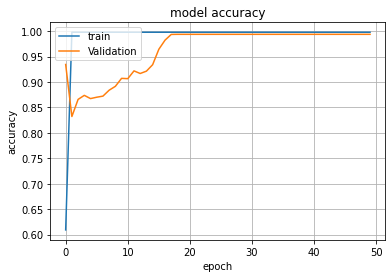

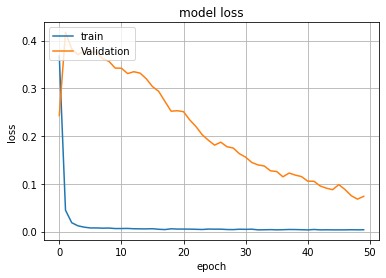

In [16]:
plot_training_data(history)

In [17]:
yhat = model.predict(test_X)
test_X_remain = test_X
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

In [18]:
inv_yhat = concatenate((yhat, test_X[:,2:]), axis=1)
inv_yhat

<tf.Tensor: shape=(291237, 9), dtype=float32, numpy=
array([[-0.00260608,  0.02112676,  0.8333334 , ...,  0.55400175,
         1.        ,  0.55399615],
       [ 0.99831843,  0.02112676,  0.8333334 , ...,  0.55399615,
         0.        ,  0.5537351 ],
       [-0.00274376,  0.02112676,  0.8333334 , ...,  0.5537351 ,
         1.        ,  0.55268604],
       ...,
       [ 0.06513363,  1.        ,  0.        , ...,  0.5541047 ,
         1.        ,  0.5541943 ],
       [ 1.1907399 ,  1.        ,  0.        , ...,  0.5541943 ,
         0.        ,  0.5541965 ],
       [ 0.0644137 ,  1.        ,  0.        , ...,  0.5541965 ,
         1.        ,  0.55336475]], dtype=float32)>

In [19]:
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat

array([[-7.81821084e+02,  8.23415466e+02,  1.19333341e+02, ...,
        -4.92990091e+01,  7.40067528e+01,  5.53996146e-01],
       [ 2.99494530e+05,  8.23415466e+02,  1.19333341e+02, ...,
        -4.92996285e+01, -5.63332969e-01,  5.53735077e-01],
       [-8.23124729e+02,  8.23415466e+02,  1.19333341e+02, ...,
        -4.93284860e+01,  7.40067528e+01,  5.52686036e-01],
       ...,
       [ 1.95400241e+04,  3.89749995e+04,  1.00000000e+00, ...,
        -4.92876308e+01,  7.40067528e+01,  5.54194272e-01],
       [ 3.57220768e+05,  3.89749995e+04,  1.00000000e+00, ...,
        -4.92777284e+01, -5.63332969e-01,  5.54196477e-01],
       [ 1.93240444e+04,  3.89749995e+04,  1.00000000e+00, ...,
        -4.92774846e+01,  7.40067528e+01,  5.53364754e-01]])

In [20]:
inv_yhat = inv_yhat[:,0]

In [21]:
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 2:]), axis=1)
inv_y

<tf.Tensor: shape=(291237, 9), dtype=float32, numpy=
array([[0.        , 0.02112676, 0.8333334 , ..., 0.55400175, 1.        ,
        0.55399615],
       [1.        , 0.02112676, 0.8333334 , ..., 0.55399615, 0.        ,
        0.5537351 ],
       [0.        , 0.02112676, 0.8333334 , ..., 0.5537351 , 1.        ,
        0.55268604],
       ...,
       [0.        , 1.        , 0.        , ..., 0.5541047 , 1.        ,
        0.5541943 ],
       [1.        , 1.        , 0.        , ..., 0.5541943 , 0.        ,
        0.5541965 ],
       [0.        , 1.        , 0.        , ..., 0.5541965 , 1.        ,
        0.55336475]], dtype=float32)>

In [22]:
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [23]:
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
rmse

35772.301012953016

In [24]:
diff=[]
ratio=[]
predictions = model.predict(test_X_remain)
p = predictions
for u in range(len(test_y)):
    pr = p[u][0]
    ratio.append((test_y[u]/pr)-1)
    diff.append(abs(test_y[u]- pr))

In [ ]:
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000

OverflowError: Exceeded cell block limit (set 'agg.path.chunksize' rcparam)

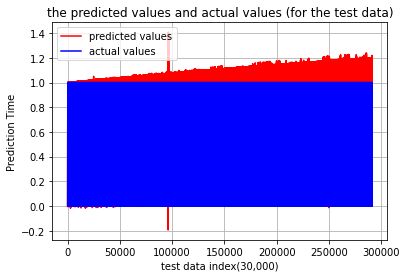

In [25]:
fig, axs = plt.subplots()

axs.plot(p,color='red', label='predicted values')
axs.plot(test_y,color='blue', label='actual values')
axs.set_title('the predicted values and actual values (for the test data)')

plt.xlabel('test data index(30,000)')
plt.ylabel('Prediction Time')
plt.legend(loc='upper left')
plt.grid()
plt.savefig('/home/ronaldsonbellande/Desktop/Data Mining/project/LSTM/Prediction_vs_Actual.png', dpi =500)
plt.show()